## Stats507 Homework 10, May 2, 2019
### Israel Diego
#### Discussed with: Hunter Zhang, Xiaochuan Guo

#### israeldi@umich.edu

This notebook shows solutions to homework 10 for Stats507

## Table of Contents

1. [Problem 1: Constructing a 3-tensor](#Problem-1:-Constructing-a-3-tensor)
2. [Problem 2: Building and training simple models](#Problem-2:-Building-and-training-simple-models)
3. [Problem 3: Building a Complicated Model](#Problem-3:-Building-a-Complicated-Model)
4. [Problem 4: Running Models on Google Cloud Platform](#Problem-4:-Running-Models-on-Google-Cloud-Platform)

### Problem 1: Constructing a 3-tensor
#### Time Spent: 30 minutes
#### ([Back to Top](#Table-of-Contents))
You may have noticed that the TensorFlow logo, seen in Figure 1 below, is a $2$-dimensional depiction of a $3$-dimensional orange structure, which casts shadows shaped like a "T" and an "F", depending on the direction of the light. The structure is five "cells" tall, four wide and three deep.

<img src="https://raw.githubusercontent.com/israeldi/israeldi.github.io/master/Stats507/Homeworks/israeldi_hw10/tensor_flow.png" alt="Drawing" style="width: 300px;"/>

Create a TensorFlow constant tensor `tflogo` with shape $5$-by-$4$-by-$3$. This tensor will represent the $5$-by-$4$-by-$3$ volume that contains the orange structure depicted in the logo (said another way, the orange structure is inscribed in this $5$-by-$4$-by-$3$ volume). Each cell of your tensor should correspond to one cell in this volume. Each entry of your tensor should be $1$ if and only if the corresponding cell is part of the orange structure, and should be $0$ otherwise. Looking at the logo, we see that the orange structure can be broken into 11 cubic cells, so your tensor tflogo should have precisely $11$ non-zero entries. For the sake of consistency, the $(0, 3, 2)$-entry of your tensor (using $0$-indexing) should correspond to the top rear corner of the structure where the cross of the "T" meets the top of the "F". **Note:** if you look carefully, the shadows in the logo do not correctly reflect the orange structure--the shadow of the "T" is incorrectly drawn. Do not let this fool you!

**Hint:** you may find it easier to create a Numpy array representing the structure first, then turn that Numpy array into a TensorFlow constant. **Second hint:** as a sanity check, try printing your tensor. You should see a series of $4$-by-$3$ matrices, as though you were looking at one horizontal slice of the tensor at a time, working your way from top to bottom.

In [2]:
import tensorflow as tf
import numpy as np
import functools

sess = tf.Session()

dim = [5, 4, 3] # dimension of tflogo
num_elems = functools.reduce(lambda x,y: x * y, dim) # Total number of elements in tflogo
one_ind = [2, 5, 8, 9, 10, 11, 20, 31, 32, 44, 56] # Indices where 1's should go

# Initialize tflogo array
tflogo_elems = np.zeros(num_elems)
tflogo_elems[one_ind] = 1

# Create tflogo.constant and reshape
tflogo = tf.constant(tflogo_elems, dtype = 'int8')
tflogo = tf.reshape(tflogo, dim)

print(tflogo.eval(session = sess))

/Users/israeldiego/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


[[[0 0 1]
  [0 0 1]
  [0 0 1]
  [1 1 1]]

 [[0 0 0]
  [0 0 0]
  [0 0 1]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 1 1]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 1]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 1]
  [0 0 0]]]


### Problem 2: Building and training simple models
#### Time Spent: 4 hours
#### ([Back to Top](#Table-of-Contents))
In this problem, you'll use TensorFlow to build the loss functions for a pair of commonly used statistical models. In all cases, your answer should include placeholder variables `x` and `ytrue`, which will serve as the predictor (independent variable) and response (dependent variable), respectively. Please use `W` to denote a parameter that multiplies the predictor, and `b` to denote a bias parameter (i.e., a parameter that is added). 
1. **Logistic regression with a negative log-likelihood loss.** In this model, which we discussed briefly in class, the binary variable $Y$ is distributed as a Bernoulli random variable with success parameter $\sigma(W^{T}X+b)$, where $\sigma(z)=(1+\textrm{exp}(-z))^{-1}$ is the logistic function, and $X\in\mathbb{R}^{6}$ is the predictor random variable, and $W\in\mathbb{R}^{6}$, $b\in\mathbb{R}$ are the model parameters. Derive the log-likelihood of $Y$, and write the TensorFlow code that represents the negative log-likelihood loss function. **Hint:** the loss should be a sum over all observations of a negative log-likelihood term.

#### Solution
First, the likelihood function $L(p)$ for a random sample $Y_{1},\ldots,Y_{n}\sim Bernoulli(p)$,
where $p=\sigma(W^{T}X+b)$ is our success parameter
is,
\begin{align*}
L(p) & =\prod_{i=1}^{n}p^{y_{i}}(1-p)^{1-y_{i}}\\
 & =p^{\sum_{i=1}^{n}y_{i}}(1-p)^{\sum_{i=1}^{n}1-y_{i}}
\end{align*}
Taking log of the likelihood function, the negative log-likelihood
is,

\begin{align*}
-\ell(p) & =-\sum_{i=1}^{n}[y_{i}log(p)+(1-y_{i})log(1-p)]\\
\end{align*}

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

x = tf.placeholder(tf.float32, shape = [None, 6]) # predictor (independent variable)
ytrue = tf.placeholder(tf.float32, shape = [None, 1]) # response (dependent variable)

# Model Parameters
W = tf.Variable(tf.zeros([6, 1]))
b = tf.Variable(tf.zeros([1]))

# logistic function
Y = tf.sigmoid(tf.matmul(x, W) + b)

# negative log-likelihood loss function
loss = tf.reduce_sum(-(ytrue * tf.log(Y)) - ((1 - ytrue) * tf.log(1 - Y)))

2. **Estimating parameters in logistic regression.** The zip file at http://www-personal.umich.edu/~klevin/teaching/Winter2019/STATS507/HW10_logistic.zip contains four Numpy `.npy` files that contain train and test data generated from a logistic model:
    - `logistic_xtest.npy` : contains a $500$-by-$6$ matrix whose rows are the independent variables (predictors) from the test set.
    - `logistic_xtrain.npy` : contains a $2000$-by-$6$ matrix whose rows are the independent variables (predictors) from the train set.
    - `logistic_ytest.npy` : contains a binary $500$-dimensional vector of dependent variables (responses) from the test set.
    - `logistic_ytrain.npy` : contains a binary $2000$-dimensional vector of dependent variables (responses) from the train set.
    
The $i$-th row of the matrix in `logistic_xtrain.npy` is the predictor for the response in the $i$-th entry of the vector in `logistic_ytrain.npy`, and analogously for the two test set files. Please include these files in your submission so that we can run your code without downloading them again. **Note:** we didn't discuss reading numpy data from files. To load the files, you can simply call `xtrain = np.load('xtrain.npy')` to read the data into the variable `xtrain`. `xtrain` will be a Numpy array.

Load the training data and use it to obtain estimates of $W$ and $b$ by minimizing the negative log-likelihood via gradient descent. **Another note:** you'll have to play around with the learning rate and the number of steps. Two good ways to check if optimization is finding a good minimizer:
   * Try printing the training data loss before and after optimization.
   * Use the test data to validate your estimated parameters.

Training data loss before optimization: 1386.2922
Training data loss after optimization: 716.14246


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Accuracy of our parameters (based on test data): 0.852


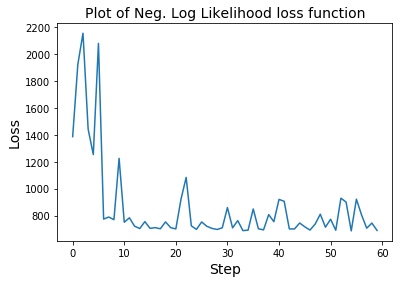

In [4]:
from IPython.display import Latex

# Load train data
xtrain = np.load('./logistic_data/logistic_xtrain.npy')
ytrain = np.load('./logistic_data/logistic_ytrain.npy')

# Load test data
xtest = np.load('./logistic_data/logistic_xtest.npy')
ytest = np.load('./logistic_data/logistic_ytest.npy')

# Specify parameters
learnRate = 0.4; n_steps = 60; batchSize = len(xtrain) // n_steps

# Initialize all global variables
init = tf.global_variables_initializer()
sess.run(init)

# Define our Gradient Descent optimizer and loss function from part 1.)
optimizer = tf.train.GradientDescentOptimizer(learnRate)
train = optimizer.minimize(loss)

# Printing loss before optimization
lossBefore = sess.run(loss, feed_dict={x: xtrain, ytrue: ytrain})
print("Training data loss before optimization: " + str(lossBefore))

# Conduct Optimization with training data using batched approach
losses = np.zeros(n_steps)
for i in range(n_steps):
    losses[i] = sess.run(loss, feed_dict = {x: xtrain, ytrue: ytrain})
    batch_x =  xtrain[batchSize * i: batchSize * (i + 1)]
    batch_ytrue = ytrain[batchSize * i: batchSize * (i + 1)]
    sess.run(train, feed_dict = {x: batch_x, ytrue: batch_ytrue})
    
# Printing loss after optimization    
lossAfter = sess.run(loss, feed_dict={x: xtrain, ytrue: ytrain})
print("Training data loss after optimization: " + str(lossAfter))

# Estimates of W and b
display(Latex('$\hat{W}_{train}=$'+ str([x[0] for x in sess.run(W)]) ))
display(Latex('$\hat{b}_{train}=$'+ str(sess.run(b)) ))

# Use test data to validate parameters
correct_prediction = tf.equal(tf.round(Y), ytrue)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
print("Accuracy of our parameters (based on test data): " + str(sess.run(accuracy, feed_dict={x: xtest, ytrue: ytest})))

# Plot our Loss function
plt.title("Plot of Neg. Log Likelihood loss function", fontsize = 14)
plt.xlabel("Step", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
_ = plt.plot(losses)

3. **Evaluating logistic regression on test data.** Load the test data. What is the negative log-likelihood of your model on this test data? That is, what is the negative log-likelihood when you use your estimated parameters with the previously unseen test data?

In [5]:
neg_log_likelihood = sess.run(loss, feed_dict = {x: xtest, ytrue: ytest})
print("The negative log-likelihood on test data is: " + str(neg_log_likelihood))

The negative log-likelihood on test data is: 170.90541


4. **Evaluating the estimated logistic parameters.** The data was, in reality, generated with

\begin{align*}
W=(1,1,2,3,5,8), & \ b=-1
\end{align*}

Write TensorFlow expressions to compute the squared error between your estimated parameters and their true values. Evaluate the error in recovering $W$ and $b$ separately. What are the squared errors? **Note:** you need only evaluate the error of your final estimates, not at every step.

In [6]:
# Specify the real values
W_Real = tf.constant(np.reshape([1, 1, 2, 3, 5, 8], [6, 1]), dtype = tf.float32)
b_Real = tf.constant([-1], dtype = tf.float32)

# Compute the squared errors between our estimates and the real values
sq_err_W = tf.reduce_sum(tf.square(W - W_Real))
sq_err_b = tf.square(b - b_Real)

# Print our squared errors
print("The Squared Error for W is:" + str(sess.run(sq_err_W)))
print("The Squared Error for b is: "+ str(sess.run(sq_err_b)[0]))

The Squared Error for W is:1.0947154
The Squared Error for b is: 0.27974698


5. For ease of grading, please make the variables from the above problems available in a dictionary called `results_logistic`. The dictionary should have keys `'W'`, `'Wsqerr'`, `'b'`, `'bsqerr'`, `'log_lik_test'`, with respective values `sess.run(x)` where `x` ranges over the corresponding quantities. For example, if my squared error for $W$ is stored in a $TF$ variable called `W_squared_error`, then the key `'Wsqerr'` should have value `sess.run(W_squared_error)`.

In [7]:
results_logistic = {'W': sess.run(W), 'Wsqerr': sess.run(sq_err_W), 
                    'b': sess.run(b), 'bsqerr': sess.run(sq_err_b), 
                    'log_lik_test': neg_log_likelihood}

6. **Classification of normally distributed data.** The .zip file at http://www-personal.umich.edu/~klevin/teaching/Winter2019/STATS507/HW10_normal.zip contains four Numpy `.npy` files that contain train and test data generated from $K = 3$ different classes. Each class $k \in \{1, 2, 3\}$ has an associated mean $\mu_k \in R$ and variance $\sigma_{k}^{2}\in\mathbb{R}$, and all observations from a given class are i.i.d. $\mathcal{N}(\mu_{k},\sigma_{k}^{2})$. The four files are:
  * `normal_xtest.npy` : contains a $500$-vector whose entries are the independent variables (predictors) from the test set.
  * `normal_xtrain.npy` : contains a $2000$-vector whose entries are the independent variables (predictors) from the train set.
  * `normal_ytest.npy` : contains a $500$-by-$3$ dimensional matrix whose rows are one-hot encodings of the class labels for the test set.
  * `normal_ytrain.npy` : contains a $2000$-by-$3$ dimensional matrix whose rows are one-hot encodings of the class labels for the train set.

The $i$-th entry of the vector in `normal_xtrain.npy` is the observed random variable from class with label given by the $i$-th row of the matrix in `normal_ytrain.npy`, and analogously for the two test set files. Please include these files in your submission so that we can run your code without downloading them again. 

Load the training data and use it to obtain estimates of the vector of class means $\mu=(\mu_{0},\mu_{1},\mu_{2})$ and variances $\sigma^{2}=(\sigma_{0}^{2},\sigma_{1}^{2},\sigma_{2}^{2})$ by minimizing the cross-entropy between the estimated normals and the one-hot encodings of the class labels (as we did in our softmax regression example in class). Please name the corresponding variables `mu` and `sigma2`. This time, instead of using gradient descent, use Adagrad, supplied by TensorFlow as the function `tf.train.AdagradOptimizer`. Adagrad is a *stochastic gradient descent algorithm*, popular in machine learning. You can call this just like the gradient descent optimizer we used in class|just supply a learning rate. Documentation for the $TF$ implementation of Adagrad can be found here: https://www.tensorflow.org/api_docs/python/tf/train/AdagradOptimizer. See https://en.wikipedia.org/wiki/Stochastic_gradient_descent for more information about stochastic gradient descent and the Adagrad algorithm. 

**Note:** you'll no longer be able to use the built-in logit cross-entropy that we used for training our models in lecture. Your cross-entropy for one observation should now look something like $-\sum_{k}y'_{k}\textrm{log}p_{k}$, where $y'$ is the one-hot encoded vector and $p$ is the vector whose $k$-th entry is the (estimated) probability of the $k$-th observation given its class. **Another note:** do not include any estimation of the mixing coefficients (i.e., the class priors) in your model. You only need to estimate three means and three variances, because we are building a *discriminative* model in this problem.

Training data loss before optimization: 5689.1797
Training data loss after optimization: 2783.872


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

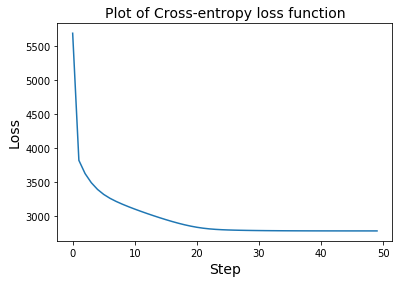

In [8]:
# Load train data
xtrain = np.load('./normal_data/normal_xtrain.npy')
ytrain = np.load('./normal_data/normal_ytrain.npy')

# Specify parameters
learnRate = 0.45; n_steps = 50

# Initialize parameters
mu = tf.Variable(tf.ones([1, 3]), dtype = tf.float32)
sigma2 = tf.Variable(tf.ones([1, 3]), dtype = tf.float32)

x = tf.placeholder(tf.float32, shape = [None, 1]) # predictor (independent variable)
ytrue = tf.placeholder(tf.float32, [None, 3]) # one-hot encoded vector

# Probability vector -------------------------------------------------------------------------------------------
p = tf.distributions.Normal(loc = mu, scale = sigma2).prob(x)

# Cross-entropy Loss Function to minimize
cross_entropy = tf.reduce_mean(-(tf.reduce_sum(ytrue * tf.log(p))))

# Optimize via Adagrad
train_step = tf.train.AdagradOptimizer(learnRate).minimize(cross_entropy)

# Initialize all global variables
init = tf.global_variables_initializer()
sess.run(init)

# Printing loss before optimization
cross_entropy_Before = sess.run(cross_entropy, feed_dict={x: xtrain, ytrue: ytrain})
print("Training data loss before optimization: " + str(cross_entropy_Before))

# Conduct Optimization with training data ----------------------------------------------------------------------
losses = np.zeros(n_steps)
for i in range(n_steps):
    losses[i] = sess.run(cross_entropy, feed_dict = {x: xtrain, ytrue: ytrain})
    sess.run(train_step, feed_dict = {x: xtrain, ytrue: ytrain})

# Printing loss after optimization    
cross_entropy_After = sess.run(cross_entropy, feed_dict = {x: xtrain, ytrue: ytrain})
print("Training data loss after optimization: " + str(cross_entropy_After))

# Estimates of W and b
display(Latex('$\hat{\mu}_{train}=$'+ str(list(sess.run(mu)[0])) ))
display(Latex('$\hat{\sigma}_{train}^{2}=$'+ str(list(sess.run(sigma2)[0]) )))

# Plot our Loss function
plt.title("Plot of Cross-entropy loss function", fontsize = 14)
plt.xlabel("Step", fontsize = 14)
plt.ylabel("Loss", fontsize = 14)
_ = plt.plot(losses)

7. **Evaluating loss on test data.** Load the test data. What is the cross-entropy of your model on this test data? That is, what is the cross-entropy when you use your estimated parameters with the previously unseen test data?

In [9]:
# Load test data
xtest = np.load('./normal_data/normal_xtest.npy')
ytest = np.load('./normal_data/normal_ytest.npy')

crossent_test = sess.run(cross_entropy, {x: xtest, ytrue: ytest})
print("The Cross-entropy on test data is: " + str(crossent_test))

The Cross-entropy on test data is: 686.2981


8. **Evaluating parameter estimation on test data.** The true parameter values for the three classes were

\begin{align*}
\mu_{0}=-1, & \sigma_{0}^{2}=0.5\\
\mu_{1}=0, & \sigma_{1}^{2}=1\\
\mu_{2}=3, & \sigma_{2}^{2}=1.5
\end{align*}

Write a TensorFlow expression to compute the total squared error (i.e., summed over the six parameters) between your estimates and their true values. What is the squared error? **Note:** you need only evaluate the error of your final estimates, not at every step.

In [10]:
mu_Real = tf.constant([[-1, 0, 3]], dtype = tf.float32)
sigma2_Real = tf.constant([[0.5, 1, 1.5]], dtype = tf.float32)

sq_err = sess.run(tf.reduce_sum((mu - mu_Real)**2) + tf.reduce_sum((sigma2 - sigma2_Real)**2))
print("total squared error: " + str(sq_err))

total squared error: 0.12180754


9. **Evaluating classification error on test data.** Write and evaluate a TensorFlow expression that computes the classification error of your estimated model averaged over the test data.

In [11]:
correct_prediction = tf.equal(tf.argmax(p, 1), tf.argmax(ytrue, 1))
error = 1 - tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
class_error = sess.run(error, {x: xtest, ytrue: ytest})
print("The Classification Error is: " + str(class_error))

The Classification Error is: 0.268


10. Again, for ease of grading, define a dictionary called `results_class`, with keys `'mu'`, `'sigma2'`, `'crossent_test'`, `'class_error'` with keys corresponding to the evaluation (again using `sess.run`) of your estimate of $\mu$, $\sigma^2$, the cross-entropy on the test set, and the classification error from the previous problem.

In [12]:
results_class = {'mu': sess.run(mu), 'sigma2': sess.run(sigma2), 
                 'crossent_test': crossent_test, 'class_error': class_error}

### Problem 3: Building a Complicated Model
#### Time Spent: 2 hours
#### ([Back to Top](#Table-of-Contents))

The TensorFlow documentation includes tutorials on building a number of more complicated neural models in TensorFlow: https://www.tensorflow.org/tutorials/. In the left side panel, choose any one tutorial from under one of the headings "ML at production scale", "Generative models", "Images" or "Sequences" and follow it. Some of the tutorials include instructions along the lines of "We didn't discuss this trick, try adding it!". You do not need to do any of these additional steps (though you will certainly learn something if you do!). **Warning:** some of the tutorials require large amounts of training data. If this is the case, please do not include the training data in your submission! Instead, include a line of code to download the data from wherever it is stored. Also, some of the tutorials require especially long training time, (e.g., the neural models) so budget your time accordingly!

Your submission for this problem should be a *separate* jupyter notebook called `tutorial.ipynb` (no need to include your uniqname), which includes code to load the training and test data, build and train a model, and evaluate that model on test data. That is, the code in `tutorial.ipynb` should perform all the training and testing steps performed in the tutorial, but without having to be run from the command line. Depending on which model you choose, training may take a long time if you use the preset number of training steps, so be sure to include a variable called `nsteps` that controls the number of training steps, and set it to be something moderately small for your submission.

**Note:** it will not be enough to simply copy the tutorial's python code into your
jupyter notebook, since the demo code supplied in the tutorials is meant to be run from
the command line.

**Another note:** If it was not clear, you are, for this problem and this problem only,
permitted to copy-paste code from the TensorFlow tutorials as much as you like without
penalty.

**One more note:** Please make sure that in both `tutorial.ipynb` and your main submission notebook `uniqname.hw10.ipynb` you do not set any training times to be excessively long. You are free to set the number of training steps as you like for running on your own machine, but please set these parameters to something more reasonable in your submission so that we do not need to wait too long when running your notebook. Aim to set the number of training steps so that we can run each of your submitted notebooks less than a minute. 

### Problem 4: Running Models on Google Cloud Platform
#### Time Spent: 5 hours
#### ([Back to Top](#Table-of-Contents))
In this problem, you'll get a bit of experience running TensorFlow jobs on Google Cloud Platform (GCP), Google's cloud computing service. Google has provided us with a grant, which will provide each of you with free compute time on GCP.

**Important:** this problem is **very hard**. It involves a sequence of fairly complicated operations in GCP. As such, I do not expect every student to complete it. Don't worry
about that. Unless you've done a lot of programming in the past, this problem is likely
your first foray into learning a new tool largely from scratch instead of having my lectures
to guide you. The ability to do this is a crucial one for any data scientist, so consider
this a learning opportunity (and a sort of miniature final exam). Start early, read the
documentation carefully, and come to office hours if you're having trouble.

Good luck, and have fun!

The first thing you should do is claim your share of the grant money by visiting this link: https://google.secure.force.com/GCPEDU?cid=VYZbhLIwytS0UVxuWxYyRYgNVxPMOf37oBx0hRmx71pfjlHwvVnxlUdVjBD6l5XA You will need to supply your name and your UMich email. Please use the email address associated to your unique name (i.e., uniqname@umich.edu), so that we can easily determine which account belongs to which student. Once you have submitted this form, you will receive a confirmation email through which you can claim your compute credits. These credits are valid on GCP until they expire in January 2020. Any credits left over after completing this homework are yours to use as you wish. Make sure that you claim your credits while signed in under your University of Michigan email, rather than a personal gmail account so that your project is correctly associated with your UMich email. If you accidentally claim the credits under a different address, add your unique name email as an owner.

Once you have claimed your credits, you should create a project, which will serve as a repository for your work on this problem. You should name your project `uniqname-stats507w19`, where `uniqname` is your unique name in all lower-case letters. Your project's billing should be automatically linked to your credits, but you can verify this fact in the billing section dashboard in the GCP browser console. Please add both me (UMID `klevin`) and your GSI Roger Fan (UMID `rogerfan`) as owners. You can do this in the IAM tab of the IAM & admin dashboard by clicking "Add" near the top of the page, and listing our UMich emails and specifying our Roles as Project ! Owner.

**Note:** this problem is comparatively complicated, and involves a lot of moving parts. At the end of this problem (several pages below), I have included a list of all the files that should be included in your submission for this problem, as well as a list of what should be on your GCP project upon submission.

**Important:** after the deadline (May 2nd at 10:00am) you **should not** edit your GCP project in any way until you receive a grade for the assignment in canvas. If your project indicates that any files or running processes have been altered after the deadline by a user other than `klevin` or `rogerfan`, we will assume this to be an instance of editing your assignment after the deadline, and you will receive a penalty.
1. Follow the tutorial at https://cloud.google.com/ml-engine/docs/distributed-tensorflow-mnist-cloud-datalab, which will walk you through the process of training a CNN similar to the one we saw in class, but this time using resources on GCP instead of your own machine. This tutorial will also have you set up a DataLab notebook, which is Google's version of a Jupyter notebook, in which you can interactively draw your own digits and pass them to your neural net for classification. **Important:** the tutorial will tell you to tear your nodes and storage down at the end. Do not do that. Leave everything running so that we can verify that you set things up correctly. It should only cost a few dollars to leave the datalab server and storage buckets running, but if you wish to conserve your credits, you can tear everything down and go through the tutorial again on the evening of May 1st or the (early!) morning of May 2nd.

2. Let us return to the classifier that you trained above on the normally-distributed data. In this and the next several subproblems, we will take an adaptation of that model and upload it to GCP where it will serve as a prediction node similar to the one you built in the tutorial above. Train the same classifier on the same training data, but this time, save the resulting trained model in a directory called `normal_trained`. You'll want to use the `tf.saved_model.simple_save` function. Refer to the GCP documentation at https://cloud.google.com/ml-engine/docs/deploying-models, and the documentation on the `tf.saved_model.simple_save` function, here: https://www.tensorflow.org/programmers_guide/saved_model#save_and_restore_models Please include a copy of this model directory in your submission. **Hint:** a stumbling block in this problem is figuring out what to supply as the inputs and outputs arguments to the `simple_save` function. Your arguments should look something like `inputs = {'x':x}`, `outputs = {'prediction':prediction}`.

3. Let's upload that model to GCP. First, we need somewhere to put your model. You already set up a bucket in the tutorial, but let's build a separate one. Create a new bucket called `uniqname-stats507w19-hw10-normal`, where `uniqname` is your uniqname. You should be able to do this by making minor changes to the commands you ran in the tutorial, or by following the instructions at https://cloud.google.com/solutions/running-distributed-tensorflow-on-compute-engine#creating_a_cloud_storage_bucket. Now, we need to upload your saved model to this bucket. There are several ways to do this, but the easiest is to follow the instructions at https://cloud.google.com/storage/docs/uploading-objects and upload your model through the GUI. **Optional challenge (worth no extra points, just bragging rights):** Instead of using the GUI, download and install the Google Cloud SDK, available at https://cloud.google.com/sdk/ and use the `gsutil` command line tool to upload your model to a storage bucket.

4. Now we need to create a *version* of your model. Versions are how the GCP machine learning tools organize different instances of the same model (e.g., the same model trained on two different data sets). To do this, follow the instructions located at https://cloud.google.com/ml-engine/docs/deploying-models#creating_a_model_version, which will ask you to
    * Upload a SavedModel directory (which you just did)
    * Create a Cloud ML Engine model resource
    * Create a Cloud ML Engine version resource (this specifies where your model is stored, among other information)
    * Enable the appropriate permissions on your account.

Please name your model `stats507w19_hw10_normal` (note the underscores here as opposed to the hyphens in the bucket name; see the documentation for the `gcloud ml-engine versions` command for how to delete versions, if need be). **Important:** there are a number of pitfalls that you may encounter here, which I want to warn you about: A good way to check that your model resource and version are set up correctly is to run the command `gcloud ml-engine versions describe "your_version_name" --model "your_model_name"`. The resulting output should include a line reading `state: READY`. You may notice that the Python version for the model appears as, say, `pythonVersion: '2.7'`, even though you used, say, Python 3.6. This should not be a problem, but you should make sure that the `runtimeVersion` is set correctly. If the line `runtimeVersion: '1.0'` is appearing when you describe your version, you are likely headed for a bug. You can prevent this bug by adding the flag `--runtime-version 1.6` to your `gcloud ml-engine versions create` command, and making sure that you are running TensorFlow version 1.6 on your local machine (i.e., the machine where you're running Jupyter). Running version 1.7 locally while running 1.6 on GCP also seems to work fine.

5. Create a .json file corresponding to a single prediction instance on the input observation $x = 4$. Name this .json file `instance.hw10.json`, and please include a copy of it in your submission. **Hint:** you will likely find it easiest to use nano/vim/emacs to edit edit the .json file from the tutorial (GCP Cloud Shell has versions of all three of these editors). Doing this will allow you to edit a copy of the .json file directly in the GCP shell instead of going through the trouble of repeatedly downloading and uploading files. Being proficient with a shell-based text editor is also, generally speaking, a good skill for a data scientist to have.

6. Okay, it's time to make a prediction. Follow the instructions at https://cloud.google.com/ml-engine/docs/online-predict#requesting_predictions to submit the observation in your .json file to your running model. Your model will make a prediction, and print the output of the model to the screen. Please include a copy-paste of the command you ran to request this prediction as well as the resulting output. Which cluster does your model think $x = 4$ came from? **Hint:** if you are getting errors about dimensions being wrong, make sure that your instance has the correct dimension expected by your model. Second hint: if you are encountering an error along the lines of `Error during model execution: AbortionError(code=StatusCode.INVALID_ARGUMENT, details=\"NodeDef mentions attr 'output_type'`, this is an indication that there is a mismatch between the version of TensorFlow that you used to create your model and the one that you are running on GCP. See the discussion of `gcloud ml-engine versions create` above.

That's all of it! Great work! Here is a list of all files that should be included for this problem in your submission, as well as a list of what processes or resources should be left running in your GCP project:
   * You should leave the datalab notebook and its supporting resources (i.e., the prediction node and storage bucket) from the GCP ML tutorial running in your GCP project.
   * Include in your submission a copy of the saved model directory constructed from your classifier. You should also have a copy of this directory in a storage bucket on GCP.
   * Leave a storage bucket running on GCP containing your uploaded model directory. This storage bucket should contain a model with a single version.
   * Include in your submission a `.json` file representing a single observation. You need not include a copy of this file in a storage bucket on GCP; it will be stored by default in your GCP home directory if you created it in a text editor in the GCP shell.
   * Include in your jupyter notebook a copy-paste of the command you ran to request your model's prediction on the .json file, and please include the output that was printed to the screen in response to that prediction request. **Note:** Please make sure that the cell(s) that you copy-paste into is/are set to be Raw NBconvert cell(s), so that your commands display as code but are not run as code by Jupyter.